# New emulator

In [1]:
%load_ext autoreload
%autoreload 2
import sys
sys.path.append("./modules")

import os
import argparse
import numpy as np
import matplotlib.pyplot as plt

from Potential import Potential
from Channel import Channel
from Scattering import Scattering
from ScatteringExp import ScatteringExp
from Grid import Grid
import RseSolver
from scipy.special import factorial2, spherical_jn
from plots.rc_params import *
from NumerovEmulator import AffineGROM

In [2]:
potentialArgs = {"label": "minnesota", "kwargs": {"potId": 213}}
l = 0
channel = Channel(S=0, L=l, LL=l, J=l, channel=0)
potential = Potential(channel, **potentialArgs)
E_MeV = 50
scattExp = ScatteringExp(E_MeV=E_MeV, potential=potential)
rmatch = 12
grid = Grid(1e-24, rmatch, numIntervals=1, numPointsPerInterval=1200,
            type="linear", test=False)  # needs equidistant grids as of now
trainingLecList, testingLecList = Potential.getSampleLecs(potentialArgs["label"])

In [3]:
rseParams = {"grid": grid, "scattExp": scattExp, "potential": scattExp.potential, 
             "inhomogeneous": True, 
             "asympParam": "K", "method": "lsqfit", 
             "matching": False,
             "lecs": testingLecList[0]
             }
lecs = np.array([1,200,-91.85])

In [4]:
np.set_printoptions(edgeitems=10, linewidth=400)
from Numerov import EverythingAllAtOnceNumerov
from RseSolver import g_s, g_s_affine
aa = EverythingAllAtOnceNumerov(xn=grid.points, g=None, 
                                g_s=g_s_affine, params=rseParams)

print(aa.S_tensor.shape)
abar = np.tensordot(lecs, aa.Abar_tensor, axes=1)
ss = np.tensordot(lecs, aa.S_tensor, axes=1)
abar
sys = np.tensordot(lecs, aa.A_tensor, axes=1)
sol_new = np.linalg.solve(sys, ss)

(3, 1200)


In [5]:
grom = AffineGROM(scattExp=scattExp,
           grid=grid, 
        #    free_lecs={"V0": (0, 400)}, 
        free_lecs={"V1": (-400, 0)}, 
           num_snapshots_init=200, 
            num_snapshots_max=50000, 
            approach="pod", 
            pod_rcond=1e-10, 
            init_snapshot_lecs=None,
            greedy_max_iter=5, 
            mode="linear",
            seed=10203
            )

using 7 out of 200 POD modes in total: compression rate is 96.5 %


/Users/cdrischler/GitHub/greedy_emulator/env/lib/python3.11/site-packages/matplotlib/cbook.py:1699: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
/Users/cdrischler/GitHub/greedy_emulator/env/lib/python3.11/site-packages/matplotlib/cbook.py:1345: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


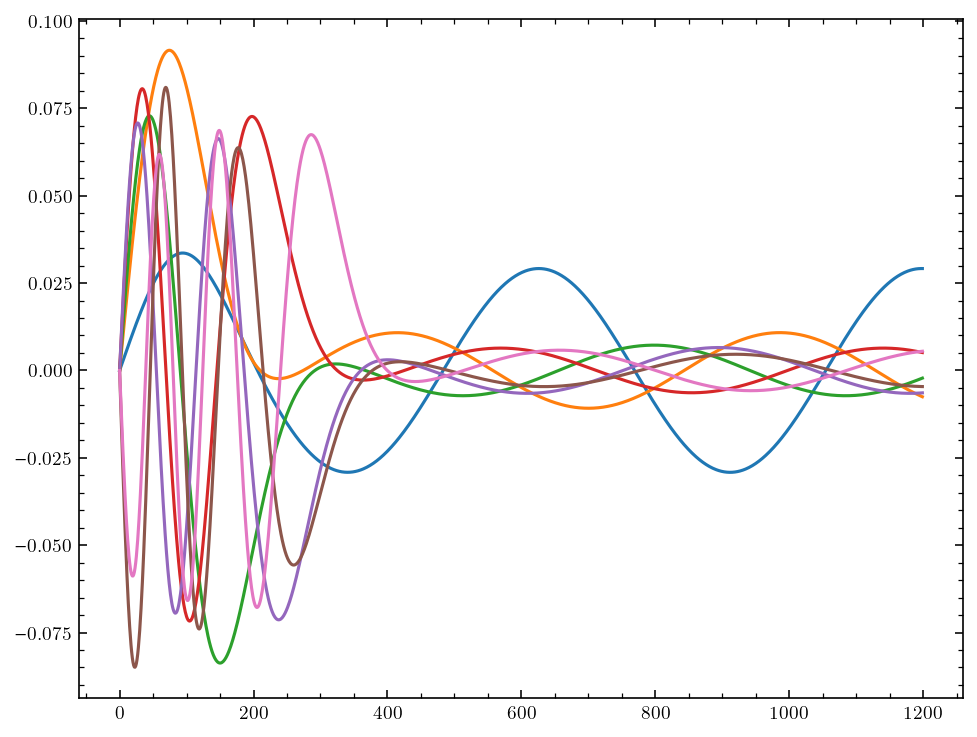

In [6]:
plt.plot(grom.snapshot_matrix[:-1])

/Users/cdrischler/GitHub/greedy_emulator/env/lib/python3.11/site-packages/matplotlib/cbook.py:1699: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
/Users/cdrischler/GitHub/greedy_emulator/env/lib/python3.11/site-packages/matplotlib/cbook.py:1345: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


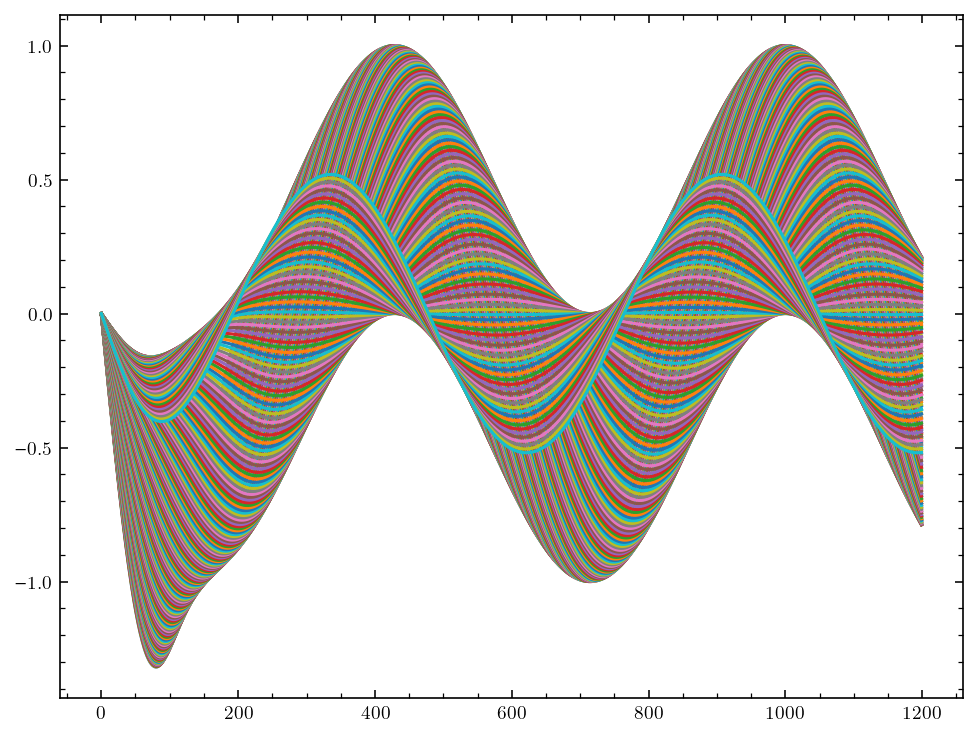

In [7]:
plt.plot(grom.fom_solutions[:-1,:])

In [8]:
grom.fom_solutions[-1,:]

array([-0.39496307+1.93398999e-01j, -0.4039494 +2.05339384e-01j, -0.41260397+2.17585479e-01j, -0.42091435+2.30127607e-01j, -0.42886842+2.42955495e-01j, -0.4364544 +2.56058290e-01j, -0.44366087+2.69424564e-01j, -0.45047683+2.83042336e-01j, -0.45689169+2.96899083e-01j, -0.46289535+3.10981763e-01j, -0.46847819+3.25276834e-01j, -0.47363112+3.39770277e-01j, -0.47834559+3.54447623e-01j,
       -0.48261365+3.69293979e-01j, -0.48642793+3.84294054e-01j, -0.4897817 +3.99432195e-01j, -0.49266887+4.14692413e-01j, -0.49508401+4.30058423e-01j, -0.49702237+4.45513670e-01j, -0.49847991+4.61041373e-01j, -0.49945329+4.76624556e-01j, -0.49993987+4.92246087e-01j, -0.49993776+5.07888717e-01j, -0.49944579+5.23535115e-01j, -0.49846351+5.39167912e-01j, -0.49699122+5.54769731e-01j,
       -0.49502994+5.70323232e-01j, -0.49258141+5.85811148e-01j, -0.48964809+6.01216321e-01j, -0.48623316+6.16521737e-01j, -0.48234047+6.31710567e-01j, -0.47797456+6.46766193e-01j, -0.47314066+6.61672250e-01j, -0.46784461+6.76412652

In [9]:
%timeit grom.emulate([lecs])
%timeit grom.simulate([lecs])

85.5 µs ± 6.28 µs per loop (mean ± std. dev. of 7 runs, 10,000 loops each)
146 µs ± 1.7 µs per loop (mean ± std. dev. of 7 runs, 10,000 loops each)


In [10]:
print(grom.emulate([lecs])[-1], grom.simulate([lecs])[-1])

[0.27710106+0.08380893j] [0.27710106+0.08380893j]


Kmat diff [1.56663571e-11-2.04469455e-10j]


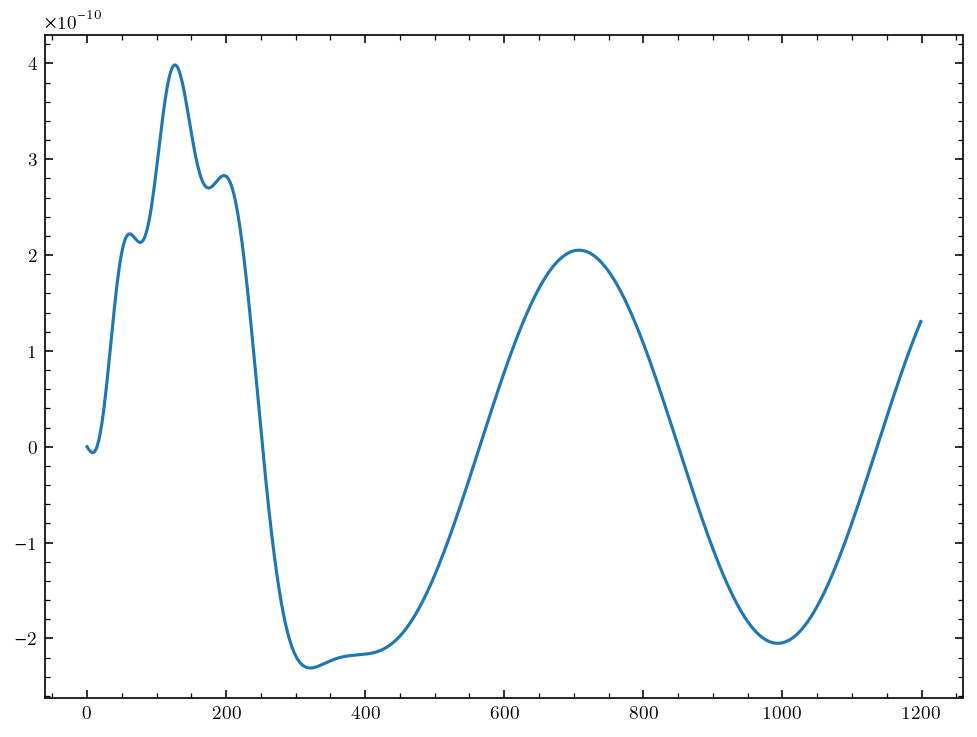

In [11]:
plt.plot((grom.emulate([lecs]) - grom.simulate([lecs]))[:-1])
print("Kmat diff", grom.emulate([lecs])[-1] - grom.simulate([lecs])[-1])

In [12]:
# np.abs(1+2j*greedy_grom.simulate([lecs])[-1])

In [13]:
# np.abs((1+2j*greedy_grom.emulate([lecs], estimate_norm_residual=True, calc_error_bounds=False, self_test=True)[0][-1]))

In [14]:
greedy_grom = AffineGROM(scattExp=scattExp,
           grid=grid, 
        #    free_lecs={"V0": (0, 400)}, 
           free_lecs={"V1": (-400, 0)}, 
           num_snapshots_init=2, 
            num_snapshots_max=200, 
            approach="greedy", 
            pod_rcond=1e-10, 
            init_snapshot_lecs=None,
            greedy_max_iter=5, 
            mode="linear",
            seed=10203
            )

snapshot idx already included in basis: {35, 149}
now greedily improving the snapshot basis:
	iteration #1 of max 5:
		estimated max error: 4.172e-04 | real max error: 4.138e+00
		coercivity constant: 9.920e+03
		adding snapshot ID 199 to current basis {35, 149}
	iteration #2 of max 5:
		estimated max error: 6.816e-05 | real max error: 4.154e-01
		coercivity constant: 6.094e+03
		adding snapshot ID 0 to current basis {35, 149, 199}
	iteration #3 of max 5:
		estimated max error: 4.819e-06 | real max error: 2.421e-02
		coercivity constant: 5.019e+03
		adding snapshot ID 95 to current basis {0, 35, 149, 199}
	iteration #4 of max 5:
		estimated max error: 6.231e-08 | real max error: 1.784e-04
		coercivity constant: 2.863e+03
		adding snapshot ID 179 to current basis {0, 35, 199, 149, 95}
	iteration #5 of max 5:
		estimated max error: 2.981e-09 | real max error: 9.009e-06
		coercivity constant: 3.022e+03


-0.0015901170486876115
-0.00666829388053336
-0.000542170586036228
8.714198692305608e-06


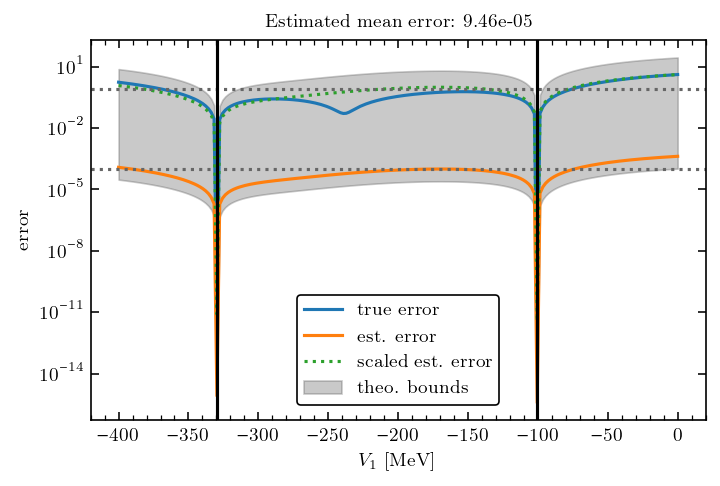

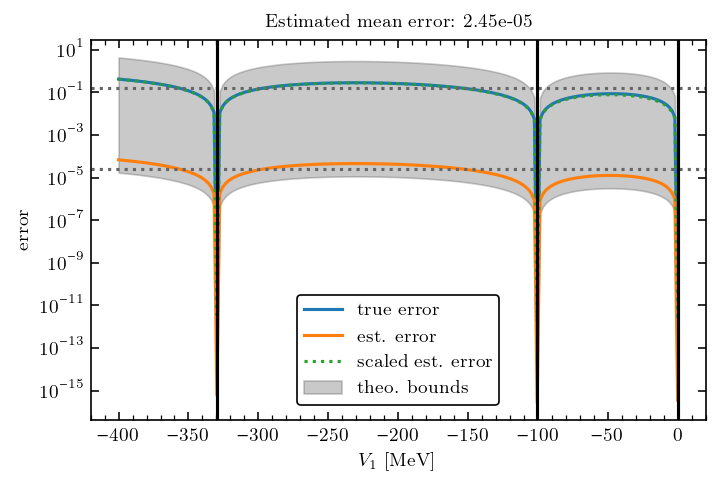

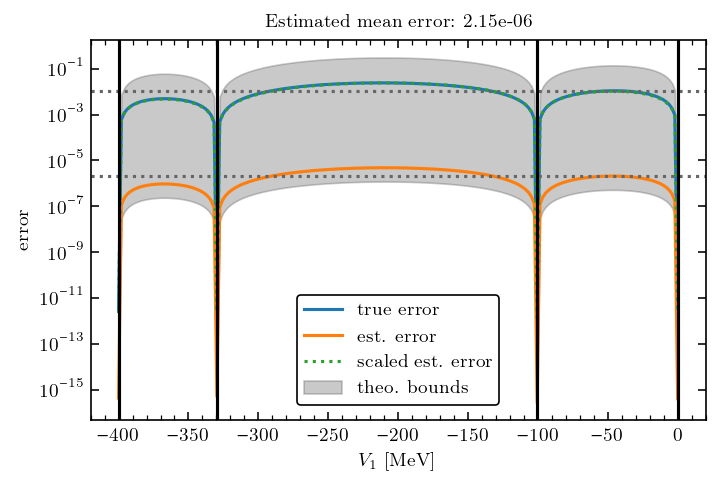

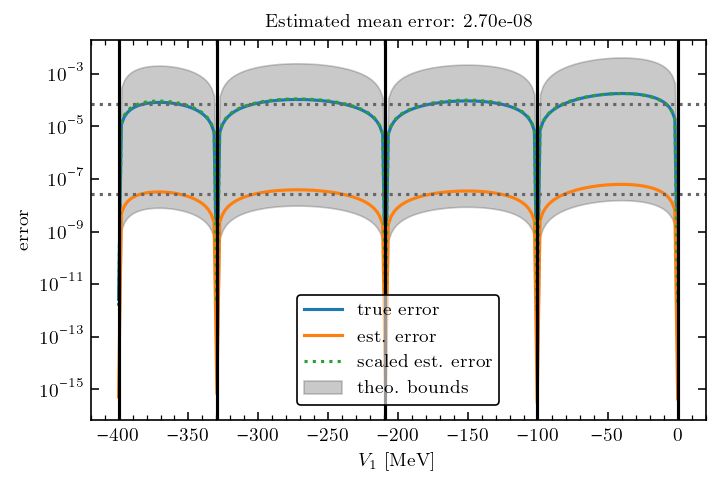

In [20]:
from constants import cm
num_iter = len(greedy_grom.greedy_logging)
V0_arr = greedy_grom.lec_all_samples[:,2]
for niter in range(num_iter-1):
    fig, ax = plt.subplots(1,1, figsize=(12*cm,8*cm), constrained_layout=True)
    ax.set_xlabel("$V_1$ [MeV]")
    ax.set_ylabel("error")
    # ax.set_ylim(1e-16, 1e0)
    [snapshot_idxs, fom_sol, emulated_sol, 
     romErrors, realErrors, estErrBounds,
     coercivity_constant] = greedy_grom.greedy_logging[niter]
    ax.semilogy(V0_arr, realErrors, label=f"true error")
    ax.semilogy(V0_arr, romErrors, ls="-", label=f"est. error")
    ax.semilogy(V0_arr, coercivity_constant*romErrors, 
                ls=":", label=f"scaled est. error")
    print(1-np.max(np.abs(emulated_sol[-1, :])))
    # print(np.max(np.abs(coercivity_constant*romErrors - realErrors)))
    # ax.semilogy(V0_arr, estErrBounds[:,0], label=f"lower bound")
    # ax.semilogy(V0_arr, estErrBounds[:,1], label=f"upper bound")
    ax.fill_between(V0_arr, estErrBounds[:,0], estErrBounds[:,1], 
                    alpha=0.3, color='0.3',
                    zorder=0, label="theo. bounds")
    for err in (romErrors,realErrors):
        ax.axhline(np.mean(err), ls=":", c='0.4')
    ax.set_title(f"Estimated mean error: {np.mean(romErrors):.2e}")

    for idx in snapshot_idxs:
        ax.axvline(V0_arr[idx], c="k")
    ax.legend().set_zorder(102)
    fig.savefig(f"iter{niter}.png")

In [16]:
import string
lowercase_alphabet = string.ascii_lowercase 
print(lowercase_alphabet) 

abcdefghijklmnopqrstuvwxyz


In [17]:
greedy_grom.lec_all_samples[:,2]

array([-400.        , -397.98994975, -395.9798995 , -393.96984925, -391.95979899, -389.94974874, -387.93969849, -385.92964824, -383.91959799, -381.90954774, -379.89949749, -377.88944724, -375.87939698, -373.86934673, -371.85929648, -369.84924623, -367.83919598, -365.82914573, -363.81909548, -361.80904523, -359.79899497, -357.78894472, -355.77889447, -353.76884422, -351.75879397, -349.74874372,
       -347.73869347, -345.72864322, -343.71859296, -341.70854271, -339.69849246, -337.68844221, -335.67839196, -333.66834171, -331.65829146, -329.64824121, -327.63819095, -325.6281407 , -323.61809045, -321.6080402 , -319.59798995, -317.5879397 , -315.57788945, -313.5678392 , -311.55778894, -309.54773869, -307.53768844, -305.52763819, -303.51758794, -301.50753769, -299.49748744, -297.48743719,
       -295.47738693, -293.46733668, -291.45728643, -289.44723618, -287.43718593, -285.42713568, -283.41708543, -281.40703518, -279.39698492, -277.38693467, -275.37688442, -273.36683417, -271.35678392, -269

In [18]:
greedy_grom.greedy_logging[4]

[{0, 35, 95, 149, 179, 199},
 array([[ 0.        +0.j        ,  0.        +0.j        ,  0.        +0.j        ,  0.        +0.j        ,  0.        +0.j        ,  0.        +0.j        ,  0.        +0.j        ,  0.        +0.j        ,  0.        +0.j        ,  0.        +0.j        , ...,  0.        +0.j        ,  0.        +0.j        ,  0.        +0.j        ,  0.        +0.j        ,  0.        +0.j        ,
          0.        +0.j        ,  0.        +0.j        ,  0.        +0.j        ,  0.        +0.j        ,  0.        +0.j        ],
        [-0.02632037+0.00750524j, -0.02618223+0.00772112j, -0.02603962+0.00793478j, -0.02589258+0.00814607j, -0.02574115+0.00835487j, -0.02558538+0.00856101j, -0.02542532+0.00876438j, -0.02526102+0.00896483j, -0.02509256+0.00916221j, -0.02492001+0.00935641j, ..., -0.00649482-0.00186762j, -0.00659674-0.0019162j , -0.00669831-0.00196142j, -0.00679943-0.00200333j, -0.00689998-0.002042j  ,
         -0.00699984-0.00207751j, -0.00709891-0.00210994j,